Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
(966, 1850)
done in 0.092s
50 37
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
Fitting the classifier to the training set
done in 61.408s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.060s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.70      0.78      0.74        27
    George W Bush       0.94      0.91      0.93       146
Gerhard Schroeder       0.77

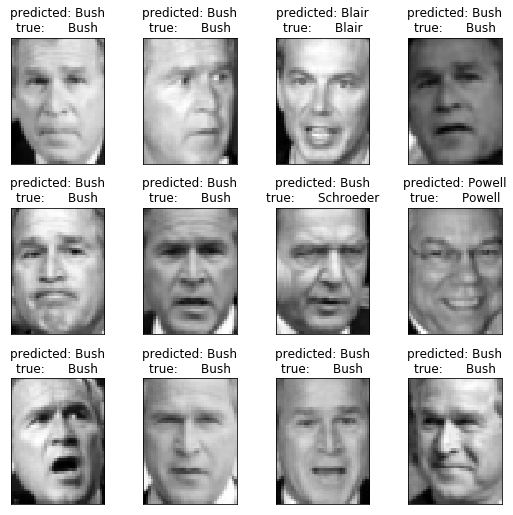

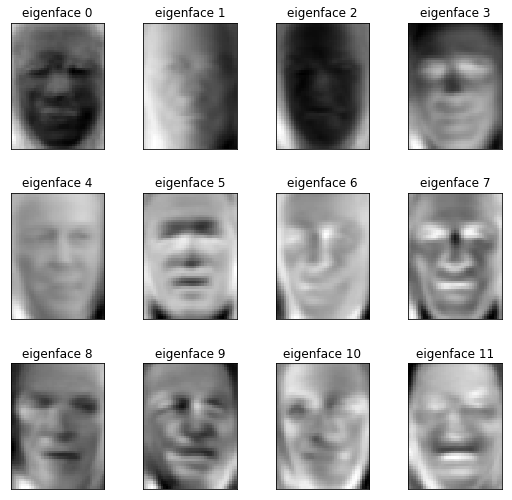

In [5]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
print(X_train.shape)
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

print('height, width')
print(h,w)
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [3]:
import cv2

def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

 
def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image
 
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = resize(image, width=w)
 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
 
        # yield the next image in the pyramid
        yield image

In [ ]:
from skimage.transform import pyramid_gaussian
import cv2
 
# METHOD #2: Resizing + Gaussian smoothing.
for (i, resized) in enumerate(pyramid_gaussian(image, downscale=2)):
    # if the image is too small, break from the loop
    if resized.shape[0] < 30 or resized.shape[1] < 30:
        break
        
    # show the resized image
    cv2.imshow("Layer {}".format(i + 1), resized)
    cv2.waitKey(0)

In [1]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [2]:
# import the necessary packages
import time
import cv2
 
# load the image and define the window width and height
image = cv2.imread("TestImage.jpeg")
(winW, winH) = (128, 128)

for (x, y, window) in sliding_window(image, stepSize=32, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
    # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
    # WINDOW

    # since we do not have a classifier, we'll just draw the window
    print(window)
    cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
    cv2.imshow("Window", clone)
    cv2.waitKey(1)
    time.sleep(0.025)


[[[216 225 228]
  [214 223 226]
  [218 227 230]
  ...
  [211 220 223]
  [215 224 227]
  [215 224 227]]

 [[214 223 226]
  [210 219 222]
  [211 220 223]
  ...
  [222 231 234]
  [221 230 233]
  [211 220 223]]

 [[220 229 232]
  [216 225 228]
  [216 225 228]
  ...
  [218 227 230]
  [218 227 230]
  [213 222 225]]

 ...

 [[224 233 236]
  [220 229 232]
  [220 229 232]
  ...
  [228 235 238]
  [237 244 247]
  [230 237 240]]

 [[227 236 239]
  [223 232 235]
  [221 230 233]
  ...
  [229 236 239]
  [238 245 248]
  [228 235 238]]

 [[218 227 230]
  [223 232 235]
  [225 234 237]
  ...
  [229 236 239]
  [233 240 243]
  [227 234 237]]]


NameError: name 'clone' is not defined

In [ ]:
def distance_eigenspace(window, average_face, weights, eigenvectors):
    # Project our window into the eigenspace (eigenvectors)
    window = np.array(window, dtype='float64').flatten()
    
    # Normalize by substracting the average face
    window -= average_face
    window = np.reshape(window, (average_face.shape[0], 1))
    
    # Projecting the window into the eigenspace
    projected = eigenvectors.transpose() * window
    
    # Finding the norm of weights minus the projection
    diff = weights - projected
    norms = np.linalg.norm(diff, axis=0)
    
    return np.linalg.norm(norms, axis=0)

In [ ]:
#used to create a sliding window which can run through the image to test whether there is a face in each position
def sliding_window(image, sizeOfStep, sizeOfWindow):
    #for each posible window position within the given range, yeild just the part of the image inside the window
    for y in range(0, image.shape[0], sizeOfStep):
        for x in range(0, image.shape[1], sizeOfStep):
            yield (x, y, image[y:y + sizeOfWindow[1], x:x + sizeOfWindow[0]])

In [ ]:
# Calculate the average face
avgFace = np.sum(totalData, axis=1) / 30

# Normalize the dataset's images by substraction the average face
for j in range(0, 30):
    totalData[:, j] -= avgFace[:]

# Calculate the covariance matrix
cov_matrix = np.matrix(totalData.transpose()) * np.matrix(totalData)

# Normalize the covariant matrix
cov_matrix /= 30

# Obtain the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Explained Variance
# Sort the eigenvalues and eigenvectors without passing
sort_indices = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[sort_indices]
eigenvectors = eigenvectors[:,sort_indices]

evalues_sum = sum(eigenvalues[:])
evalues_count = 0
evalues_energy = 0.0
for evalue in eigenvalues:
    evalues_count += 1
    evalues_energy += evalue / evalues_sum

    if evalues_energy >= 0.85:
        break

eigenvalues = eigenvalues[0:evalues_count]
eigenvectors = eigenvectors[:,0:evalues_count]


eigenvectors = totalData * eigenvectors
norms = np.linalg.norm(eigenvectors, axis=0)
eigenvectors = eigenvectors / norms

weights = eigenvectors.transpose() * totalData

In [ ]:
(winW, winH) = (128, 128)
step=32

image = np.array(cv2.imread("TestImage.jpeg",0), dtype='float64')
faceDetectImage = image.copy()
imageList = []

for (x, y, window) in sliding_window(image, sizeOfStep=step, sizeOfWindow=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue
    # Calculate the distance between the window and the eigenspace
    window_distance = distance_eigenspace(window, avgFace, weights, eigenvectors)
    
    if (window_distance < 56500):
        print (window_distance)
        cv2.rectangle(faceDetectImage, (x, y), (x + winW, y + winH), (255,255,255), 2)
        window = cropWindow(image,y,x,winH,winW)
        imageList.append(np.array(window.tolist()))

# print(imageList[0].shape)
# for i in range(i,len(imageList)):
#     plt.figure(figsize = (5,5))
#     plt.subplot(111)
#     plt.xticks([]), plt.yticks([])
#     plt.imshow(imageList[i], cmap="gray")
        
plt.figure(figsize = (10,10))
plt.subplot(111)
plt.title("Detected Faces"), plt.xticks([]), plt.yticks([])
plt.imshow(faceDetectImage, cmap="gray")

In [ ]:
def get_globaldataset():
    directories = ["face1", "face2", "face3"]
    dataset = np.empty(shape=(128*128, 30), dtype='float64')
    
    cur_img = 0
    for directory in directories:
        for file_path in os.listdir("./dataset/" + directory):
            if (not file_path.startswith(".")):
                img = np.array(cv2.resize(cv2.imread("./dataset/" + directory + "/" + file_path, 0), (128, 128)), dtype='float64').flatten()
                dataset[:, cur_img] = img[:]
                cur_img += 1
    return dataset

# Get all the image samples
global_dataset = np.array(get_globaldataset())

# Calculate the average face
average_face = np.sum(global_dataset, axis=1) / 30

# Normalize the dataset's images by substraction the average face
for j in xrange(0, 30):
    global_dataset[:, j] -= average_face[:]

# Calculate the covariance matrix
cov_matrix = np.matrix(global_dataset.transpose()) * np.matrix(global_dataset)
# Normalize the covariant matrix
cov_matrix /= 30
# Obtain the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Explained Variance
# Sort the eigenvalues and eigenvectors without passing
sort_indices = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[sort_indices]
eigenvectors = eigenvectors[:,sort_indices]

evalues_sum = sum(eigenvalues[:])
evalues_count = 0
evalues_energy = 0.0
for evalue in eigenvalues:
    evalues_count += 1
    evalues_energy += evalue / evalues_sum

    if evalues_energy >= 0.85:
        break

eigenvalues = eigenvalues[0:evalues_count]
eigenvectors = eigenvectors[:,0:evalues_count]

#evects = evects.transpose()
eigenvectors = global_dataset * eigenvectors
norms = np.linalg.norm(eigenvectors, axis=0)
eigenvectors = eigenvectors / norms

weights = eigenvectors.transpose() * global_dataset

In [ ]:

window_height = 128
window_width = 128
step_size = 48

# Create sliding windows
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            
def distance_eigenspace(window, average_face, weights, eigenvectors):
    # Project our window into the eigenspace (eigenvectors)
    window = np.array(window, dtype='float64').flatten()
    
    # Normalize by substracting the average face
    window -= average_face
    window = np.reshape(window, (128*128, 1))
    
    # Projecting the window into the eigenspace
    projected = eigenvectors.transpose() * window
    
    # Finding the norm of weights minus the projection
    diff = weights - projected
    norms = np.linalg.norm(diff, axis=0)
    
    return np.linalg.norm(norms, axis=0)

group_image = np.array(cv2.imread("./dataset/group_picture.jpg", 0), dtype='float64')
detection_image = group_image.copy()

for (x, y, window) in sliding_window(group_image, stepSize=step_size, windowSize=(window_width, window_height)):
    if window.shape[0] != window_height or window.shape[1] != window_width:
        continue
    # Calculate the distance between the window and the eigenspace
    window_distance = distance_eigenspace(window, average_face, weights, eigenvectors)

    if (window_distance < 47000):
        print (window_distance)
        cv2.rectangle(detection_image, (x, y), (x + window_width, y + window_height), (255,255,255), 2)

plt.figure(figsize = (10,10))
plt.subplot(111)
plt.title("Face Detection"), plt.xticks([]), plt.yticks([])
plt.imshow(detection_image, cmap="gray")